# 03 - Service Effectiveness

Measure how effectively states convert spending into outcomes.

**Metrics:**
- Education: NAEP test scores, graduation rates, college readiness
- Infrastructure: ASCE grades, road condition ratings
- Public safety: crime rates (FBI UCR)
- Health: child health outcomes, infant mortality

**Output:** `service_effectiveness.json`, `service_effectiveness.csv`

In [1]:
import sys, os, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from dotenv import load_dotenv

sys.path.insert(0, str(Path("..").resolve()))
from src.data_utils import (
    fetch_naep_scores, fetch_fbi_crime_data, load_cdc_infant_mortality,
)

load_dotenv(Path("../.env"))

RAW_DIR = Path("../data/raw")
PROCESSED_DIR = Path("../data/processed")
CHARTS_DIR = Path("../docs/charts/data")
RAW_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
CHARTS_DIR.mkdir(parents=True, exist_ok=True)

In [2]:
def normalize_to_100(series, invert=False):
    """Min-max normalize a series to 0-100.
    
    Args:
        series: pandas Series of raw values
        invert: if True, higher raw values produce lower scores
                (use for metrics where lower is better, like crime rates)
    """
    min_val = series.min()
    max_val = series.max()
    if max_val == min_val:
        return pd.Series(50.0, index=series.index)
    normalized = (series - min_val) / (max_val - min_val) * 100
    if invert:
        normalized = 100 - normalized
    return normalized

# Fetch NAEP math + reading scores (grade 8)
math_scores = fetch_naep_scores(subject="mathematics", grade=8)
reading_scores = fetch_naep_scores(subject="reading", grade=8)

# Average math and reading scores
education = math_scores[["state", "state_name"]].copy()
education = education.merge(
    math_scores[["state", "score"]].rename(columns={"score": "math_score"}),
    on="state",
)
education = education.merge(
    reading_scores[["state", "score"]].rename(columns={"score": "reading_score"}),
    on="state",
)
education["avg_score"] = (education["math_score"] + education["reading_score"]) / 2

print(f"Education data: {len(education)} states")
print(f"Average score range: {education['avg_score'].min():.0f} – {education['avg_score'].max():.0f}")
education.sort_values("avg_score", ascending=False).head(10)

Using embedded NAEP mathematics data (fallback)


Using embedded NAEP reading data (fallback)
Education data: 51 states
Average score range: 254 – 283


,state,state_name,math_score,reading_score,avg_score
20,MA,Massachusetts,292.0,274.0,283.0
29,NJ,New Jersey,288.0,271.0,279.5
28,NH,New Hampshire,288.0,271.0,279.5
22,MN,Minnesota,288.0,270.0,279.0
44,VT,Vermont,286.0,270.0,278.0
25,MT,Montana,286.0,269.0,277.5
33,ND,North Dakota,286.0,268.0,277.0
45,VA,Virginia,284.0,267.0,275.5
26,NE,Nebraska,284.0,267.0,275.5
49,WY,Wyoming,284.0,267.0,275.5


In [3]:
# Fetch FBI violent crime rates
FBI_API_KEY = os.environ.get("FBI_API_KEY", "")
crime = fetch_fbi_crime_data(FBI_API_KEY)
print(f"Crime data: {len(crime)} states")
print(f"Violent crime rate range: {crime['violent_crime'].min():.0f} – "
      f"{crime['violent_crime'].max():.0f} per 100k")
crime.sort_values("violent_crime", ascending=False).head(10)

Using embedded FBI crime data (fallback)
Crime data: 51 states
Violent crime rate range: 109 – 838 per 100k


,state,state_name,violent_crime
1,AK,Alaska,838.0
30,NM,New Mexico,832.0
50,DC,District of Columbia,812.0
41,TN,Tennessee,672.0
3,AR,Arkansas,580.0
17,LA,Louisiana,564.0
39,SC,South Carolina,530.0
24,MO,Missouri,502.0
2,AZ,Arizona,485.0
21,MI,Michigan,461.0


In [4]:
# Load CDC infant mortality data
mortality = load_cdc_infant_mortality()
print(f"Mortality data: {len(mortality)} states")
print(f"Infant mortality rate range: {mortality['infant_mort_rate'].min():.1f} – "
      f"{mortality['infant_mort_rate'].max():.1f} per 1,000 live births")
mortality.sort_values("infant_mort_rate", ascending=False).head(10)

Using embedded CDC infant mortality data (fallback)
Mortality data: 51 states
Infant mortality rate range: 3.7 – 8.7 per 1,000 live births


,state,state_name,infant_mort_rate
23,MS,Mississippi,8.7
17,LA,Louisiana,8.0
50,DC,District of Columbia,7.9
3,AR,Arkansas,7.8
0,AL,Alabama,7.6
35,OK,Oklahoma,7.2
41,TN,Tennessee,7.1
9,GA,Georgia,7.1
47,WV,West Virginia,7.0
32,NC,North Carolina,6.9


In [5]:
# Merge all metrics and normalize to 0-100 composite score
effectiveness = education[["state", "state_name", "avg_score"]].merge(
    crime[["state", "violent_crime"]], on="state", how="inner"
).merge(
    mortality[["state", "infant_mort_rate"]], on="state", how="inner"
)

# Normalize: education higher=better, crime lower=better (invert), mortality lower=better (invert)
effectiveness["education_score"] = normalize_to_100(effectiveness["avg_score"])
effectiveness["safety_score"] = normalize_to_100(effectiveness["violent_crime"], invert=True)
effectiveness["health_score"] = normalize_to_100(effectiveness["infant_mort_rate"], invert=True)

# Composite = simple average of three normalized scores
effectiveness["composite_score"] = (
    effectiveness["education_score"]
    + effectiveness["safety_score"]
    + effectiveness["health_score"]
) / 3

print(f"States with all 3 metrics: {len(effectiveness)}")
print(f"Composite score range: {effectiveness['composite_score'].min():.1f}/100 – "
      f"{effectiveness['composite_score'].max():.1f}/100")
print(f"Mean composite: {effectiveness['composite_score'].mean():.1f}/100")

# Display with formatted scores
display_df = effectiveness[["state", "state_name", "avg_score", "violent_crime",
                             "infant_mort_rate", "education_score", "safety_score",
                             "health_score", "composite_score"]].copy()
for col in ["education_score", "safety_score", "health_score", "composite_score"]:
    display_df[col] = display_df[col].apply(lambda x: f"{x:.1f}/100")
display_df["violent_crime"] = display_df["violent_crime"].apply(lambda x: f"{x:.0f} per 100K")
display_df["infant_mort_rate"] = display_df["infant_mort_rate"].apply(lambda x: f"{x:.1f} per 1K")
display_df.sort_values("state_name").head(10)

States with all 3 metrics: 51
Composite score range: 6.5/100 – 90.9/100
Mean composite: 58.5/100


,state,state_name,avg_score,violent_crime,infant_mort_rate,education_score,safety_score,health_score,composite_score
0,AL,Alabama,259.5,453 per 100K,7.6 per 1K,17.5/100,52.8/100,22.0/100,30.8/100
1,AK,Alaska,264.0,838 per 100K,5.8 per 1K,33.3/100,0.0/100,58.0/100,30.4/100
2,AZ,Arizona,269.0,485 per 100K,5.5 per 1K,50.9/100,48.4/100,64.0/100,54.4/100
3,AR,Arkansas,264.5,580 per 100K,7.8 per 1K,35.1/100,35.4/100,18.0/100,29.5/100
4,CA,California,268.0,442 per 100K,4.2 per 1K,47.4/100,54.3/100,90.0/100,63.9/100
5,CO,Colorado,275.0,424 per 100K,4.6 per 1K,71.9/100,56.8/100,82.0/100,70.2/100
6,CT,Connecticut,274.5,181 per 100K,4.4 per 1K,70.2/100,90.1/100,86.0/100,82.1/100
7,DE,Delaware,268.5,431 per 100K,6.6 per 1K,49.1/100,55.8/100,42.0/100,49.0/100
50,DC,District of Columbia,254.5,812 per 100K,7.9 per 1K,0.0/100,3.6/100,16.0/100,6.5/100
8,FL,Florida,272.0,384 per 100K,6.1 per 1K,61.4/100,62.3/100,52.0/100,58.6/100


In [6]:
# Export to CSV and JSON
export_cols = [
    "state", "state_name", "education_score", "safety_score",
    "health_score", "composite_score",
]
out = effectiveness[export_cols].sort_values("state").reset_index(drop=True)

csv_path = PROCESSED_DIR / "service_effectiveness.csv"
out.to_csv(csv_path, index=False)
print(f"Wrote {csv_path}")

json_path = CHARTS_DIR / "service_effectiveness.json"
out.to_json(json_path, orient="records", indent=2)
print(f"Wrote {json_path}")

Wrote ../data/processed/service_effectiveness.csv
Wrote ../docs/charts/data/service_effectiveness.json


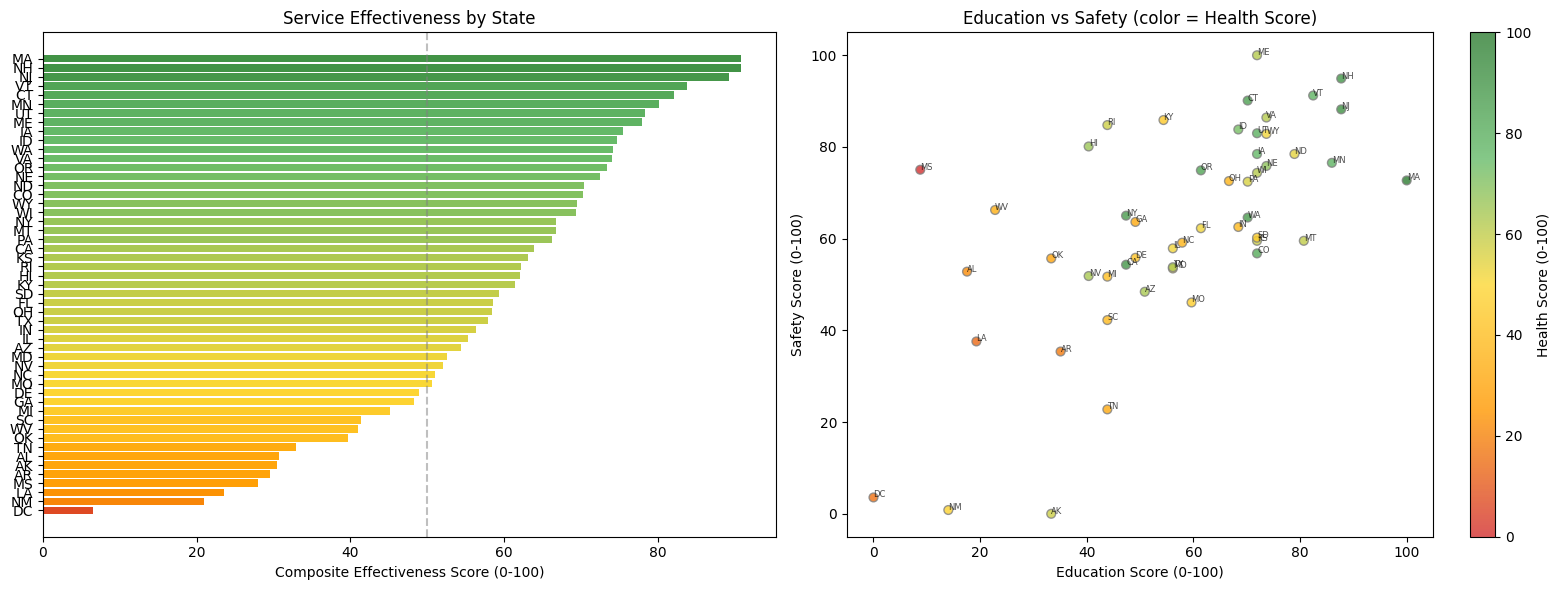

In [7]:
# Visualization
from matplotlib.colors import LinearSegmentedColormap
SCORE_CMAP = LinearSegmentedColormap.from_list("score", ["#d32f2f", "#ff9800", "#fdd835", "#66bb6a", "#2e7d32"])

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart — composite scores
ax1 = axes[0]
plot_data = out.sort_values("composite_score", ascending=True)
colors = SCORE_CMAP(plot_data["composite_score"] / 100)
ax1.barh(plot_data["state"], plot_data["composite_score"], color=colors)
ax1.set_xlabel("Composite Effectiveness Score (0-100)")
ax1.set_title("Service Effectiveness by State")
ax1.axvline(x=50, color="gray", linestyle="--", alpha=0.5)

# Scatter — education vs safety
ax2 = axes[1]
ax2.scatter(out["education_score"], out["safety_score"],
            c=out["health_score"], cmap=SCORE_CMAP, s=40, alpha=0.8, edgecolors="gray")
for _, row in out.iterrows():
    ax2.annotate(row["state"], (row["education_score"], row["safety_score"]),
                 fontsize=6, alpha=0.7)
ax2.set_xlabel("Education Score (0-100)")
ax2.set_ylabel("Safety Score (0-100)")
ax2.set_title("Education vs Safety (color = Health Score)")
cbar = plt.colorbar(ax2.collections[0], ax=ax2, label="Health Score (0-100)")

plt.tight_layout()
plt.show()

In [8]:
import plotly.express as px

SCORE_SCALE = [[0, "#d32f2f"], [0.25, "#ff9800"], [0.5, "#fdd835"], [0.75, "#66bb6a"], [1, "#2e7d32"]]

fig = px.choropleth(
    out,
    locations="state",
    locationmode="USA-states",
    color="composite_score",
    color_continuous_scale=SCORE_SCALE,
    range_color=[0, 100],
    scope="usa",
    hover_name="state_name",
    hover_data={
        "state": False,
        "composite_score": ":.1f",
        "education_score": ":.1f",
        "safety_score": ":.1f",
        "health_score": ":.1f",
    },
    labels={
        "composite_score": "Composite Score (0-100)",
        "education_score": "Education (0-100)",
        "safety_score": "Safety (0-100)",
        "health_score": "Health (0-100)",
    },
    title="Service Effectiveness — Composite Score",
)
fig.update_layout(
    coloraxis_colorbar=dict(title="Score"),
    geo=dict(lakecolor="rgb(255,255,255)"),
)
fig.show()

In [9]:
# Subcategory maps — Education, Safety, Health scores
from plotly.subplots import make_subplots
import plotly.graph_objects as go

SCORE_SCALE = [[0, "#d32f2f"], [0.25, "#ff9800"], [0.5, "#fdd835"], [0.75, "#66bb6a"], [1, "#2e7d32"]]

fig = make_subplots(
    rows=1, cols=3,
    specs=[[{"type": "choropleth"}, {"type": "choropleth"}, {"type": "choropleth"}]],
    subplot_titles=["Education Score (0-100)", "Safety Score (0-100)", "Health Score (0-100)"],
)

for i, (col, title) in enumerate([
    ("education_score", "Education"),
    ("safety_score", "Safety"),
    ("health_score", "Health"),
], start=1):
    fig.add_trace(go.Choropleth(
        locations=out["state"],
        z=out[col],
        locationmode="USA-states",
        colorscale=SCORE_SCALE,
        zmin=0, zmax=100,
        colorbar=dict(title=title, x=-0.05 + i * 0.38, len=0.8),
        hovertext=out["state_name"],
        hovertemplate="%{hovertext}<br>" + title + " Score: %{z:.1f}/100<extra></extra>",
    ), row=1, col=i)

fig.update_geos(scope="usa", lakecolor="rgb(255,255,255)")
fig.update_layout(title_text="Service Effectiveness — Component Scores", height=400)
fig.show()